Size of:
- Training-set:		37882
- Validation-set:	6262


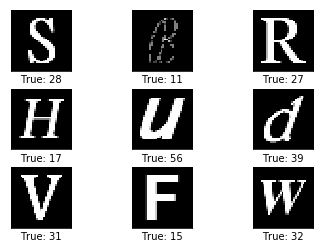

In [49]:
# -*- coding: utf-8 -*-
"""
Created on Thu May 24 00:21:41 2018

@author: aditya.sharma
"""

# In[1]:


import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import random

tf.__version__


# ### *Step 1:* Loading data
# The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

# In[2]:


class DataSet(object):

    def __init__(self, images, labels, img_names, cls):
        self._num_examples = images.shape[0]

        self._images = images
        self._labels = labels
        self._img_names = img_names
        self._index_in_epoch = 0
        self._epochs_done = 0
        self._cls = cls

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def img_names(self):
        return self._img_names

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            # After each epoch we update this
            self._epochs_done += 1
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._img_names[start:end], self._cls[start:end]
    

def load_data(input_path, dataset_type, image_size):
    images = []
    labels = []
    img_names = []
    cls = []
    
    data_path = os.path.join(input_path, str(dataset_type+'-set'))
    label_path = os.path.join(input_path, str(dataset_type+'.txt'))
    with open(label_path, 'r') as label_file:
        lines = label_file.readlines()
        random.shuffle(lines)
        for line in lines:
            filename, index = line.split(' ')
            label = np.zeros(62)
            label[int(index)] = 1.0
            labels.append(label)
            
            
            img_names.append(filename)
            image_file_path = os.path.join(data_path, filename)
            image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
            image = np.reshape(image, image_size*image_size)
            images.append(image)
            cls.append(int(index))
    images = np.array(images)
    labels = np.array(labels)
    img_names = np.array(img_names)
    cls = np.array(cls)

            
    return DataSet(images, labels, img_names, cls)
            

def read_train_sets(input_path, image_size):
    class DataSets(object):
        pass
    data_sets = DataSets()
    
    data_sets.train = load_data(input_path, 'train', image_size)
    data_sets.validation = load_data(input_path, 'vali', image_size)
    
    return data_sets
    
 
# In[3]: load data

input_path = '../Input/'
validation_size = 0.2
img_size = 32
num_channels = 1
num_classes = 62
batch_size = 32




data = read_train_sets(input_path, img_size)

# The MNIST data-set has now been loaded and consists of 70,000 images and associated labels (i.e. classifications of 
# the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and 
# validation-sets in this tutorial.

# In[3]:


print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
#print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))


# The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are 
# zero except for one element. The index of this one element is the class-number, that is, the digit shown in the 
# associated image. We also need the class-numbers as integers for the validation-set, so we calculate it now.

# ### Helper-function for plotting images - MNIST

# In[4]:


def plot_images(images, cls_true, img_shape=None, cls_pred=None):
    assert len(images) == len(cls_true) == 9

    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((img_size,img_size)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


images = data.validation.images[0:9]
cls_true = data.validation.cls[0:9]

plot_images(images=images, cls_true=cls_true)


img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 62


In [89]:
def batch_norm(x, n_out, phase_train):
    """
    Batch normalization on convolutional maps.
    Ref.: http://stackoverflow.com/questions/33949786/how-could-i-use-batch-normalization-in-tensorflow
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope('bn'):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0,1,2], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

In [90]:
activation_dictionary = {'relu':tf.nn.relu,'lrelu':tf.nn.leaky_relu,'tanh':tf.nn.tanh,'sigmoid':tf.nn.sigmoid}

def new_weights(shape):
    new_weight = tf.truncated_normal(shape, stddev=0.05)
    return tf.Variable(new_weight)

def new_biases(length):
    new_bias = tf.constant(0.05, shape=[length])
    return tf.Variable(new_bias)

def new_conv_layer(previous_layer,p):
    weights = new_weights(shape=[p['fSize'], p['fSize'], p['channels'], p['fN']])
    biases = new_biases(length=p['fN'])
    
    layer = tf.nn.conv2d(input=previous_layer, filter=weights, strides=[1, p['sSize'], p['sSize'], 1], padding='SAME')
    layer += biases
    layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #layer = tf.layers.batch_normalization(layer, training=training)
    layer = batch_norm(layer, p['fN'], training)
    
    activation = activation_dictionary[p['activation']]
    layer = activation(layer)
    return layer, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features


def new_fc_layer(input, num_inputs, num_outputs, activation='relu', dropout=0.05): 
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    layer = tf.layers.batch_normalization(layer, training=training)
    if activation != 'None':
        activation = activation_dictionary[p['activation']]
        layer = activation(layer)
    layer = tf.nn.dropout(layer, 1-dropout)
    return layer, weights

In [91]:
# Set parameters for CNN layers
convolution_params = {
    'layer_1a':{'fSize':3,'fN':16,'sSize':1,'activation':'relu','channels':1,'maxpool':True,'batch_norm':True},
    'layer_1b':{'fSize':5,'fN':16,'sSize':1,'activation':'relu','channels':1,'maxpool':True,'batch_norm':True},
    'layer_1c':{'fSize':7,'fN':16,'sSize':1,'activation':'relu','channels':1,'maxpool':True,'batch_norm':True},
    
    'layer_2a':{'fSize':3,'fN':32,'sSize':1,'activation':'relu','channels':48,'maxpool':True,'batch_norm':True},
    'layer_2b':{'fSize':5,'fN':32,'sSize':1,'activation':'relu','channels':48,'maxpool':True,'batch_norm':True},
    'layer_2c':{'fSize':7,'fN':32,'sSize':1,'activation':'relu','channels':48,'maxpool':True,'batch_norm':True},
    
    'layer_3':{'fSize':5,'fN':128,'sSize':1,'activation':'relu','channels':96,'maxpool':True,'batch_norm':True},
    
    'layer_4':{'fSize':5,'fN':256,'sSize':1,'activation':'relu','channels':128,'maxpool':True,'batch_norm':True}
}

fc_params = {
    'layer_1':{'nodes':500,'activation':'relu','dropout':0.2,'batch_norm':True},
    'layer_2':{'nodes':500,'activation':'None','dropout':0.2,'batch_norm':True}
}

reg_constant = 0.1
train_batch_size = 100




In [92]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='label')
y_true_class = tf.argmax(y_true, axis=1)

x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, 1])

training = tf.placeholder(tf.bool)

p = convolution_params['layer_1a']
layer_conv1a, weights_conv1 = new_conv_layer(previous_layer=x_image, p=p)
p = convolution_params['layer_1b']
layer_conv1b, weights_conv1 = new_conv_layer(previous_layer=x_image, p=p)
p = convolution_params['layer_1c']
layer_conv1c, weights_conv1 = new_conv_layer(previous_layer=x_image, p=p)
layer_conv1 = tf.concat([layer_conv1a,layer_conv1b,layer_conv1c], 3)

p = convolution_params['layer_2a']
layer_conv2a, weights_conv2 = new_conv_layer(previous_layer=layer_conv1, p=p) 
p = convolution_params['layer_2b']
layer_conv2b, weights_conv2 = new_conv_layer(previous_layer=layer_conv1, p=p) 
p = convolution_params['layer_2c']
layer_conv2c, weights_conv2 = new_conv_layer(previous_layer=layer_conv1, p=p) 
layer_conv2 = tf.concat([layer_conv2a,layer_conv2b,layer_conv2c], 3)

p = convolution_params['layer_3']
layer_conv3, weights_conv3 = new_conv_layer(previous_layer=layer_conv2, p=p) 

p = convolution_params['layer_4']
layer_conv4, weights_conv4 = new_conv_layer(previous_layer=layer_conv3, p=p)


layer_flat, num_features = flatten_layer(layer_conv4)

p = fc_params['layer_1']
layer_fc1, fc1_weights = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=p['nodes'],
                         activation=p['activation'])

p = fc_params['layer_2']
layer_fc2, fc2_weights = new_fc_layer(input=layer_fc1,
                         num_inputs=p['nodes'],
                         num_outputs=num_classes,
                         activation=p['activation'])


y_hat = tf.nn.softmax(layer_fc2)
y_hat_class = tf.argmax(y_hat, axis=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)

cost = tf.reduce_mean(cross_entropy)
regularizers = tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc2_weights)
cost = tf.reduce_mean(cost + reg_constant * regularizers)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_hat_class, y_true_class)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [93]:
def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    global train_scores

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        x_batch, y_true_batch, _, _ = data.train.next_batch(train_batch_size)

        feed_dict_train = {x: x_batch, y_true: y_true_batch, training:True}
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            session.run(optimizer, feed_dict=feed_dict_train)

        if i % 10 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            train_scores.append(acc)
            if i % 100 == 0:
                msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
                print(msg.format(i + 1, acc))

    total_iterations += num_iterations
    time_dif = time.time() - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))


validation_batch_size = 256

def print_validation_accuracy():
    num_validation = len(data.validation.images)
    cls_pred = np.zeros(shape=num_validation, dtype=np.int)
    i = 0

    while i < num_validation:
        j = min(i + validation_batch_size, num_validation)
        images = data.validation.images[i:j, :]
        labels = data.validation.labels[i:j, :]
        feed_dict = {x: images, y_true: labels, training:False}
        cls_pred[i:j] = session.run(y_hat_class, feed_dict=feed_dict)
        i = j
    cls_true = data.validation.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_validation
    msg = "Accuracy on validation-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_validation))

In [94]:
# Counter for total number of iterations performed so far.

train_batch_size = 128
total_iterations = 0
train_scores = []

np.random.seed(10)

session = tf.Session()
session.run(tf.global_variables_initializer())

optimize(num_iterations=201)
print_validation_accuracy()

Optimization Iteration:      1, Training Accuracy:   6.2%
Time usage: 0:01:28
Accuracy on validation-Set: 15.6% (977 / 6262)


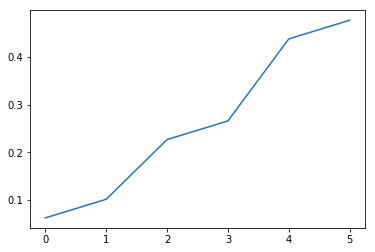

In [95]:
plt.plot(train_scores)